In [0]:
import numpy as np
import pickle
import cv2
from os import listdir
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [22]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [23]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#4/EAHvxOwTUUc5P4f054p_XPb6LUtIp67TjDF6lZaN8qOKZAuMbtL9Fow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!ls "/content/drive/My Drive/Mini-Project"


 file   imgs.zip   Potato.zip  'Untitled folder'


In [0]:
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = './Potato'
width=256
height=256
depth=3

In [26]:
!unzip "/content/drive/My Drive/Mini-Project/file/Potato.zip"

Archive:  /content/drive/My Drive/Mini-Project/file/Potato.zip
replace Potato/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Potato/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: Potato/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: Potato/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: Potato/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: Potato/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: Potato/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: Potato/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: Potato/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506_

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None


In [28]:
image_list, label_list = [], []
try:
    print("Images are being loaded...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("Images loading successfully!")  
except Exception as e:
    print(f"Error : {e}")


Images are being loaded...
Processing Potato___Early_blight ...
Processing Potato___healthy ...
Processing Potato___Late_blight ...
Processing Potato___Early_blight ...
Processing Potato___healthy ...
Processing Potato___Late_blight ...
Processing Potato___Early_blight ...
Processing Potato___healthy ...
Processing Potato___Late_blight ...
Images loading successfully!


In [0]:
image_size = len(image_list)

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
# pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [31]:


print(label_binarizer.classes_)



['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']


In [0]:


np_image_list = np.array(image_list, dtype=np.float16) / 225.0



In [33]:
print("Data is to be spilt into Train set and Test set")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

Data is to be spilt into Train set and Test set


In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")


In [0]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
    
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(1024))
model.add(Activation("relu"))

model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [36]:


model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 85, 85, 64)        0         
__________

In [37]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("TRAINING")

TRAINING


In [38]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/15
41/41 [==============================] - 28s 694ms/step - loss: 0.3388 - acc: 0.9118 - val_loss: 3.3326 - val_acc: 0.7018
Epoch 2/15
41/41 [==============================] - 27s 651ms/step - loss: 0.1936 - acc: 0.9370 - val_loss: 0.8771 - val_acc: 0.8343
Epoch 3/15
41/41 [==============================] - 28s 677ms/step - loss: 0.2015 - acc: 0.9343 - val_loss: 1.1950 - val_acc: 0.8052
Epoch 4/15
41/41 [==============================] - 27s 660ms/step - loss: 0.1239 - acc: 0.9514 - val_loss: 1.0405 - val_acc: 0.8434
Epoch 5/15
41/41 [==============================] - 27s 656ms/step - loss: 0.1236 - acc: 0.9549 - val_loss: 0.6662 - val_acc: 0.8655
Epoch 6/15
41/41 [==============================] - 25s 612ms/step - loss: 0.1091 - acc: 0.9591 - val_loss: 0.7955 - val_acc: 0.8725
Epoch 7/15
41/41 [==============================] - 25s 599ms/step - loss: 0.0892 - acc: 0.9667 - val_loss: 0.7499 - val_acc: 0.8715
Epoch 8/15
41/41 [==============================] - 25s 601ms/step - 

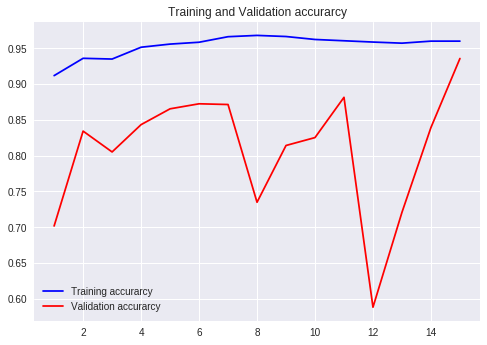

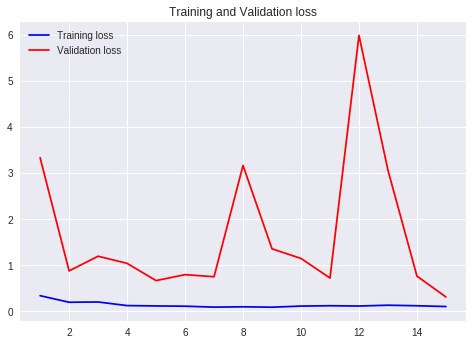

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()



In [40]:
print("Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"ACCURACY IS: {scores[1]*100}")


Calculating model accuracy
332/332 [==============================] - 2s 5ms/step
ACCURACY IS: 93.57429872076194
